# General data reader for AQUA 
## Spatial (weighted field) averaging

When we instantiate the reader object, grid areas for the source files are computed if not already available. If regridding is requested, these are computed also for the destination grid. After this we can use the computed grid_areas to do for example spatial averaging using the `fldmean` method. 

In [1]:
from aqua import Reader

### Example 1: IFS


We read some IFS data

In [2]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d")
data = reader.retrieve()

2023-11-30 15:30:25 :: eccodes :: WARNING  -> ShortName tprate have multiple grib codes associated: ['260048', '172228']
2023-11-30 15:30:25 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right


The first time the reader is instantiated, if not already available, cell area files are computed and stored in the directory specified in `config/regrid.yaml`. Notice that this operation needs to be performed once for each data source. 

The grid cell areas are available and stored in the reader. The following grid cell areas are available:
- `reader.src_grid_area`: the grid cell areas of the original grid
- `reader.dst_grid_area`: the grid cell areas of the destination grid (if regridding is used)
- `reader.grid_area`    : the source or destination grid cell areas, depending if regridding has already been performed or not


Let's pick only part of the data

In [3]:
data

<xarray.Dataset>
Dimensions:  (time: 8329, value: 26306560, level: 6)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * level    (level) int64 0 1 2 3 4 5
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Data variables: (12/82)
    100si    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    uvb      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vike     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipie    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipile   (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vithe    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [4]:
tas1=data['2t'].isel(time=range(0,96))

We can now compute a field average and plot the resulting timeseries

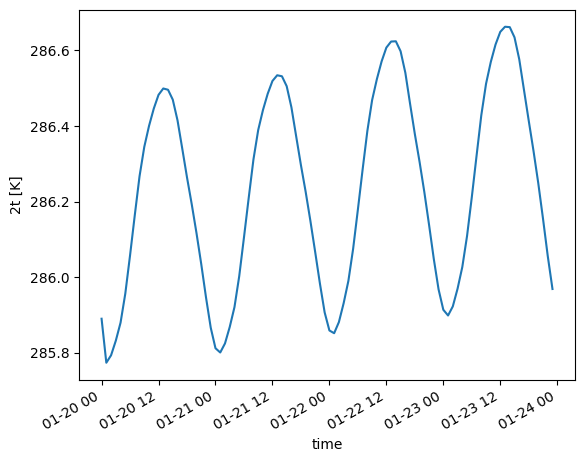

In [5]:
global_mean = reader.fldmean(tas1)
global_mean.plot()

### Example 2: ICON

Let's start without interpolation

In [6]:
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09")
data = reader.retrieve()

2023-11-30 15:30:57 :: eccodes :: WARNING  -> ShortName tprate have multiple grib codes associated: ['260048', '172228']
2023-11-30 15:30:57 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right
2023-11-30 15:30:57 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-11-30 15:30:57 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right
2023-11-30 15:30:57 :: Reader :: ERROR    -> Variable cfh_lnd has no units!


Let's demonstrate how we can compute a timeseries of global (field) averages. Instatiating the reader has also computed grid areas (stored internally in the reader object). Since no regridding has been requested the reader assumes that we wish to work with the original data. Let's extract a short timeseries of fields. The first frame for this data source is not valid.

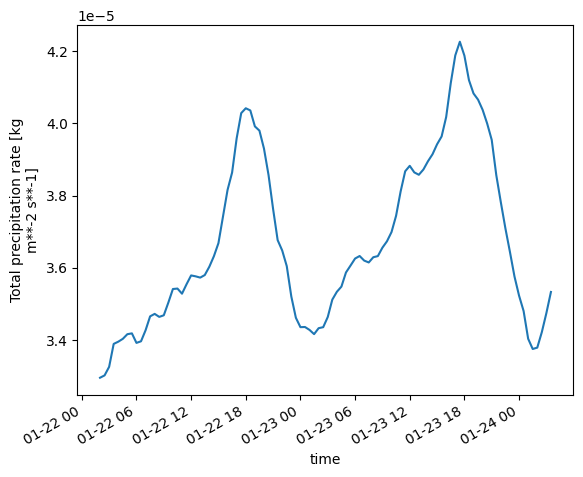

In [7]:
tas1 = data.tprate[100:200,:]
global_mean = reader.fldmean(tas1)
global_mean.plot()

Now let's ask for regridding instead.

Instantiate a reader for ICON data specifying that we will want to interpolate to a 1 deg grid (the grids are defined in the regrid.yaml file and the weights saved in a special directory). If the weights file does not already exist in our collection it will be created automatically.

In [8]:
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09", regrid="r100", fix=False)

Load the actual data. By default these data have not been regridded yet. 

In [9]:
data = reader.retrieve()

2023-11-30 15:31:01 :: Reader :: ERROR    -> Variable cfh_lnd has no units!
2023-11-30 15:31:01 :: Reader :: ERROR    -> Variable sic has no units!


Now we actually regrid part of the data

In [10]:
tasr = reader.regrid(data.tas.isel(time=range(100, 200))) 

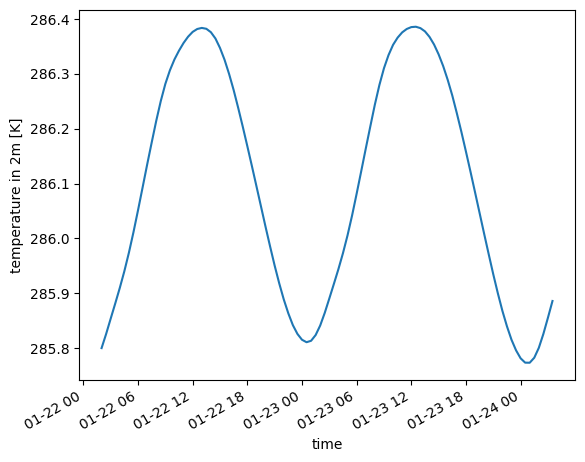

In [11]:
global_mean_r = reader.fldmean(tasr)
global_mean_r.plot()

How much do the global averages done on the interpolated and original fields differ ?

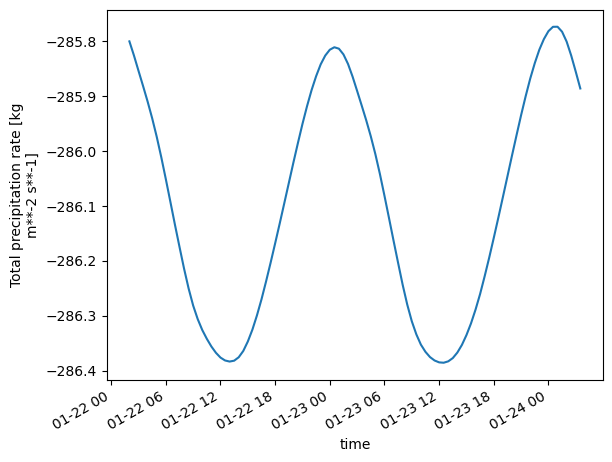

In [12]:
(global_mean - global_mean_r).plot()

The same average could have been performed directly using the cell areas:

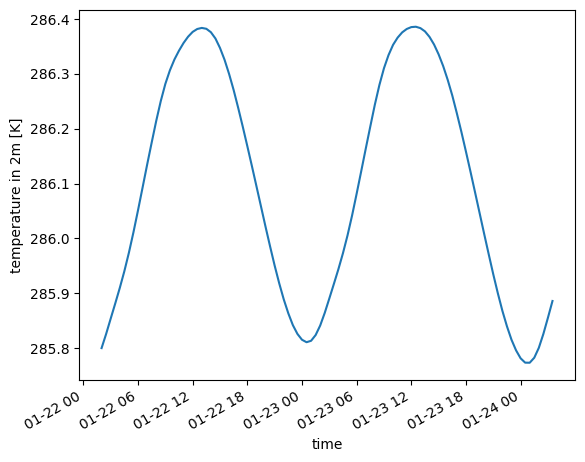

In [13]:
tasr.weighted(weights=reader.dst_grid_area).mean(dim=reader.dst_space_coord).plot()

### Example 5: Original FESOM data - further interpolation

In [14]:
from aqua import Reader
reader = Reader(model="FESOM", exp="tco2559-ng5-cycle3", source="2D_daily_native", regrid="r250")

Retrieving and plotting it

2023-11-30 15:32:50 :: eccodes :: WARNING  -> ShortName sst have multiple grib codes associated: ['34', '151159']
2023-11-30 15:32:50 :: eccodes :: WARNING  -> AQUA will take the first so that sst -> 34, please set up a correct fix if this does not look right
2023-11-30 15:32:50 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-11-30 15:32:50 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right
2023-11-30 15:32:50 :: eccodes :: WARNING  -> ShortName wo have multiple grib codes associated: ['262507', '151133']
2023-11-30 15:32:50 :: eccodes :: WARNING  -> AQUA will take the first so that wo -> 262507, please set up a correct fix if this does not look right
2023-11-30 15:32:50 :: eccodes :: WARNING  -> ShortName so have multiple grib codes associated: ['262500', '151130']
2023-11-30 15:32:50 :: eccodes :: WARNING  -> AQUA will take the first so that so -> 262500, p

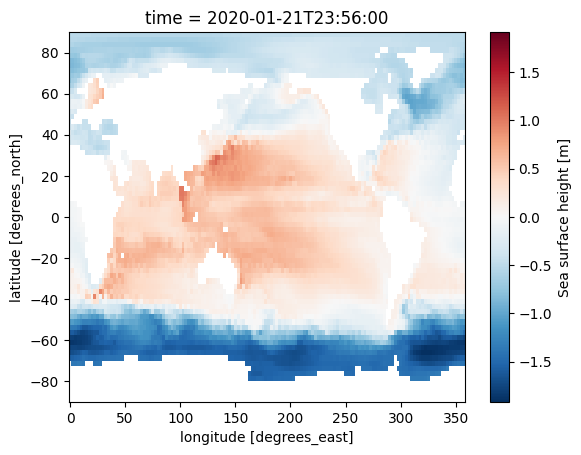

In [15]:
data = reader.retrieve()
reader.regrid(data['zos'])[1,:,:].plot()

A timeseries directly from the original data:

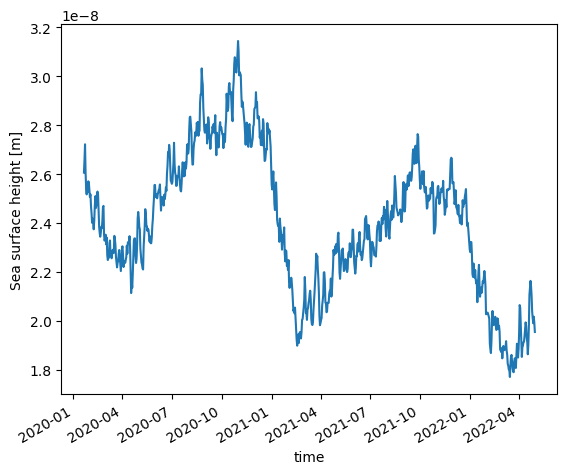

In [16]:
sst = data['zos'].isel(time=range(0,832))
reader.fldmean(sst).plot()